In [1]:
# this is a code generating the number of each mutation types using a VAE

import sys
sys.path.append("/kaggle/input/vae-code")

In [2]:
# extract the data
import pandas as pd

from fetch_data import fetch_data



df_mutant= fetch_data("../../cosmic_data/Cosmic_MutantCensus_v101_GRCh38.tsv.gz")  #  mutant census 


df_sample = fetch_data("../../cosmic_data/Cosmic_Sample_v102_GRCh38.tsv.gz")


df_classification = fetch_data("../../cosmic_data/Cosmic_Classification_v102_GRCh38.tsv.gz")

len(df_mutant)




c:\Users\25193\OneDrive - andrew.cmu.edu\Desktop\ClassMaterial\Research\code\VAE\mutation_count\fetch_data.py:7: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t', compression='gzip')


1984965

In [3]:
print(df_mutant.shape)
print(df_sample.shape)
print(df_classification.shape)

print(df_mutant.iloc[0])



(1984965, 26)
(1558299, 34)
(7125, 11)
GENE_SYMBOL                                        PRRX1
COSMIC_GENE_ID                                COSG107040
TRANSCRIPT_ACCESSION                  ENST00000239461.10
COSMIC_SAMPLE_ID                             COSS2263047
SAMPLE_NAME                              TCGA-QS-A5YR-01
COSMIC_PHENOTYPE_ID                         COSO29025463
GENOMIC_MUTATION_ID                         COSV53411170
LEGACY_MUTATION_ID                           COSM8306980
MUTATION_ID                                    102542767
MUTATION_CDS                                    c.386G>A
MUTATION_AA                                      p.R129H
MUTATION_DESCRIPTION                    missense_variant
MUTATION_ZYGOSITY                                    NaN
LOH                                                  NaN
CHROMOSOME                                             1
GENOME_START                                 170719870.0
GENOME_STOP                                  1707

In [4]:
from fetch_data import merge_extract, get_data
df_mut_complete= merge_extract(df_mutant=df_mutant, df_classification=df_classification, df_sample=df_sample)
 
df_vae= get_data(df_mut_comp=df_mut_complete)

len(df_vae)



17386

In [5]:

import numpy as np
data = np.log1p(df_vae[["SNP", "INS", "DEL"]].values, dtype=np.float32)  # log(count + 1) # transform data to log for modeling count as gaussian



In [6]:
import wandb, os
os.environ['WANDB_API_KEY']= '3e1cd1820b6eca2c89bc0f449ca37be9338d16f6'
wandb.login()

wandb: Currently logged in as: ajotie (ajotie-cmu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:

sweep_config = {
    'method': 'grid',
    'metric': {'name': 'loss', 'goal': 'minimize'},
    'parameters': {
        'lr': {'values': [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3]},
        'optimizer': {'values': [ 'adam', 'sgd', 'rmsprop' ] }, 
        'batch_size': {'values':  [32, 64, 128] }, 
        'epochs': {'values': [100, 150, 200, 250, 300]}, 
        'beta': {'values': [0.5, 1, 2, 4, 6]} 
    }
}
wandb.init()



In [8]:
sweep_id = wandb.sweep(sweep_config, project="Generative_AI_cancer")

Create sweep with ID: year9tnb
Sweep URL: https://wandb.ai/ajotie-cmu/Generative_AI_cancer/sweeps/year9tnb


In [ ]:
import torch
from VAE import train_vae
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_sweep(config = None):
    with wandb.init(config=config) as run:
        run.name=f"GENAI_mutcount_{wandb.config.lr}_{wandb.config.batch_size}_{wandb.config.optimizer}"
        config = wandb.config
        model, train_losses, val_losses, recon_trains, recon_vals, kld_trains, kld_vals = train_vae(input_dim=3, 
                                                                                            hidden_dim= 16, 
                                                                                            latent_dim=2, 
                                                                                            num_epochs=config['epochs'], 
                                                                                            batch_size= config['batch_size'], 
                                                                                            optim_val= config['optimizer'], 
                                                                                            beta= config['beta']
                                                                                            learning_rate= config['lr'], 
                                                                                            data=data, 
                                                                                            device=device )
        model.eval()
    with torch.no_grad():
        # Sample latent vectors from standard normal
        z = torch.randn(len(df_vae), 2)
        generated_log_counts = model.decode(z)
        # Convert back to counts
        generated_counts = torch.expm1(generated_log_counts).clamp(min=0).round().int()
    counts_array = generated_counts.numpy()

    # Create DataFrame
    df_gen = pd.DataFrame(
        counts_array,
        columns=['SNP', 'INS', 'DEL']
    )

    df_gen['Donor_ID'] = [f'Donor_{i+1}' for i in range(len(df_gen))]
    df_vae.loc[:, 'Donor_ID'] = [f'Donor_{i+1}' for i in range(len(df_vae))]
    df_long = df_gen.melt(
    id_vars=['Donor_ID'],
    value_vars=['SNP', 'INS', 'DEL'],
    var_name='Mutation_Type',
    value_name='Count'
    )

    # Total mutations per donor
    df_long['Total'] = df_long.groupby('Donor_ID')['Count'].transform('sum')

    # Proportion
    df_long['Proportion'] = df_long['Count'] / df_long['Total']
    df_long_real = df_vae.melt(
    id_vars=['Donor_ID'],
    value_vars=['SNP', 'INS', 'DEL'],
    var_name='Mutation_Type',
    value_name='Count'
    )

    # Total mutations per donor
    df_long_real['Total'] = df_long_real.groupby('Donor_ID')['Count'].transform('sum')

    # Proportion
    df_long_real['Proportion'] = df_long_real['Count'] / df_long_real['Total']

    real_snp = df_vae['SNP'].values
    synth_snp = df_gen['SNP'].values

    real_ins = df_vae['INS'].values
    synth_ins = df_gen['INS'].values

    real_del = df_vae['DEL'].values
    synth_del = df_gen['DEL'].values

    from scipy.stats import wasserstein_distance

    w_snp = wasserstein_distance(real_snp, synth_snp)
    w_ins = wasserstein_distance(real_ins, synth_ins)
    w_del = wasserstein_distance(real_del, synth_del)
    wandb.init()
    wandb.log({'w_snp': w_snp, 'w_ins': w_ins, 'w_del': w_del})
    
    
    






In [10]:

wandb.agent(sweep_id, train_sweep, count=30)






wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: y6yriw38 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 1e-05
wandb: 	optimizer: adam


Epoch [100/100], Train Loss: 0.97, Val Loss: 0.97


kl_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_val,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▅▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_train,0.38656
kl_val,0.38358
lr,0
train_elbo,0.97361
val_elbo,0.97166


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.28857
w_ins,0.05286
w_snp,4.23939


wandb: Agent Starting Run: 6h84ur43 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 1e-05
wandb: 	optimizer: sgd


Epoch [100/100], Train Loss: 0.98, Val Loss: 0.97


kl_train,▁▃▃▃▃▃▄▃▄▄▄▅▄▅▅▆▆▆▇▇▇▇▇█████████▇███████
kl_val,▁▂▁▂▂▂▃▃▃▂▃▃▃▃▃▅▅▅▄▅▆▆▆▆▇▇█▇▇▇▇▇████▇█▇█
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▂▁▂▂▂▂▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁
kl_train,0.41611
kl_val,0.40307
lr,0
train_elbo,0.98021
val_elbo,0.96539


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.25906
w_ins,0.05286
w_snp,4.09042


wandb: Agent Starting Run: xcho9dug with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 1e-05
wandb: 	optimizer: rmsprop


Epoch [100/100], Train Loss: 1.04, Val Loss: 1.01


kl_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_val,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_train,0.34685
kl_val,0.32873
lr,0
train_elbo,1.0367
val_elbo,1.00794


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.41694
w_ins,0.05286
w_snp,4.43403


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jndk7chu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0001
wandb: 	optimizer: adam


Epoch [100/100], Train Loss: 0.97, Val Loss: 0.93


kl_train,▄▅▂▄▄▁▃▆█▆█▆▇█▅▄▃▄▆▄▃█▆▄▆▅▄▆▂▄▂▅▂█▅▆▂▃▄▆
kl_val,█▄▃▄▁▁▂▄▃▃▂▃▂▃▃▄▃▃▄▂▄▃▃▂▃▃▂▃▄▁▃▃▃▃▂▁▃▂▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▅▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▂▂▂▁▂▁▂▂▁
kl_train,0.41621
kl_val,0.39687
lr,0.0001
train_elbo,0.96726
val_elbo,0.92956


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.29581
w_ins,0.05286
w_snp,3.79506


wandb: Agent Starting Run: h1v340fa with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0001
wandb: 	optimizer: sgd


Epoch [100/100], Train Loss: 0.96, Val Loss: 0.96


kl_train,▁▆▄▄▅▃▃▆▆▆▆▅▆▅▆▄▄▅▃▆▅█▇▅▅▂▆█▇▅▅▄▇▅▄▃▆▇▆▄
kl_val,▁▄▄▅▂▄▇▅▄▇▂▅▃▃▄▂▃▃▄▃█▄▄▅▄▄▆▄█▄▇▃▂▄▆▂▅▄▆▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▂▂▁▁▁▁▂▂
val_elbo,█▆▆▅▆▇▅▆▅▅▇▇▃▄▄▂▃▃▃▆▁▇▅▄█▅▃▄▃▆▃▅▃▄▄▄▄▅▃▁
kl_train,0.39838
kl_val,0.39859
lr,0.0001
train_elbo,0.95613
val_elbo,0.95761


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.29
w_ins,0.05286
w_snp,4.03278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: am9essv0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0001
wandb: 	optimizer: rmsprop


Epoch [100/100], Train Loss: 0.95, Val Loss: 0.95


kl_train,▄▂▁▂▂▂▂▄▅▇██▇▇▇▇▇█▇▇▆▇▇▇▇██▇▇▇█▇█▇▇▇██▇▇
kl_val,▂▁▃▁▂▂▄▃▃▃▅▆▆▇▅▇▅▆▆█▅█▆▆█▆▆▇▅▇▆▆▇▆▆▇▇▇▇▇
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▆▅▃▃▃▃▃▂▂▁▂▁▁▂▁▂▂▂▂▂▁▂▁▁▂▂▁▂▂▁▁▂▂▁▂▁▁▁▂
kl_train,0.40129
kl_val,0.37968
lr,0.0001
train_elbo,0.95147
val_elbo,0.94873


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.24014
w_ins,0.05286
w_snp,3.69061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o5w5zsss with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0005
wandb: 	optimizer: adam


Epoch [100/100], Train Loss: 0.95, Val Loss: 0.95


kl_train,█▁▇▆▆▆▇▅▇▆▆▆▆▅▆▅▄▅▅▆▆▅▄▅▅▆▅▅▄▅▅▅▅▅▆▄▄▄▅▅
kl_val,▁▄▄▅▆▅█▅▆▅▅▆▅▇▅▅▆▆▅▄▆▅▄▆▄▅▆▅▃▅▆▅▆▆▅▅▅▅▄▆
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▅▇▅▇▄▅▅▅▄▂▅▄▄▃▃▄▅▄▄▅▃▃▃▄▄▄▄▃▁▄▃▃▃▄▄▃▂▃▃
val_elbo,▇█▂▆▄▆▅▆▆▅▅▃▄▃▄▅▅▅▄▄▃▅▃▃▃▄▄▄▂▄▆▄▅▁▄▆▃▆▂▂
kl_train,0.40276
kl_val,0.40487
lr,0.0005
train_elbo,0.95001
val_elbo,0.95287


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.23876
w_ins,0.05286
w_snp,3.86351


wandb: Agent Starting Run: owpw149u with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0005
wandb: 	optimizer: sgd


Epoch [100/100], Train Loss: 0.96, Val Loss: 0.96


kl_train,▁▇█▆▆▆▅▅▆▆▆▅▆▄▆▅▆▆▆▆▆▆▅▅▄▆▅▅▄▆▅▅▅▅▄▆▅▄▅▄
kl_val,▂▆▄▅▂▅▄▆▁▁▄▅▂▆▃▆▅▄▂▅▆▇▅▆▅▄▅▃▅▇▅▃▂▇▆█▄▄▆▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_elbo,▄▂▃▃▁▄▄▅▄▁▂█▂▃▄▃▂▃▂▁▃▂▃▁▃▂▃▃▃▃▃▃▃▃▃▃▃▄▃▆
kl_train,0.39221
kl_val,0.35552
lr,0.0005
train_elbo,0.95672
val_elbo,0.95842


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.29133
w_ins,0.05286
w_snp,3.98901


wandb: Agent Starting Run: 5uminnf1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.0005
wandb: 	optimizer: rmsprop


Epoch [100/100], Train Loss: 0.95, Val Loss: 0.95


kl_train,▁▁▁██▇███▇▇▇██▇▇▆▇▇▇█▆▇▇▇▇▆▆▆▇▇▆▇▇▆▆▇▇▆▆
kl_val,▁▂██▆▆▅▆▆▇▆▇▇▅▄▆▆▅▅▆▅▆▅▅▃▅▆▄▆▅▆▆▆▇▆▆▆▅▅▅
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▄▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_elbo,█▇▃▃▃▄▃▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▃▂▂▁▂▂▂▂▂▃▂▂▁▂▂▁▂▁
kl_train,0.38646
kl_val,0.39684
lr,0.0005
train_elbo,0.94883
val_elbo,0.95206


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.27539
w_ins,0.05286
w_snp,3.98505


wandb: Agent Starting Run: 1x1y5vll with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.001
wandb: 	optimizer: adam


Epoch [100/100], Train Loss: 0.95, Val Loss: 0.93


kl_train,▆▅█▇▅▄▆▄▃▄▄▃▃▃▄▄▂▂▂▂▃▃▄▃▁▁▃▁▂▂▁▁▂▃▃▂▂▂▃▁
kl_val,▄▂▃▅▄▃▇▁▂▂▃█▅▃▅▄▁▃▃▄▃▃▂▁▃▃▅▃▃▄▄▄▃▃▃▄▆▂▂▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▄▅▃▃▅▄▄▄▃▂▂▃▃▂▃▂▁▂▂▃▂▂▂▂▃▂▂▁▂▃▁▁▂▂▂▂▃▃▂
kl_train,0.38969
kl_val,0.38575
lr,0.001
train_elbo,0.9493
val_elbo,0.93205


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.26176
w_ins,0.05286
w_snp,3.68233


wandb: Agent Starting Run: q4u6oc4i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.001
wandb: 	optimizer: sgd


Epoch [100/100], Train Loss: 2.28, Val Loss: 2.30


kl_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁▁▁▁█▂▂▁▁▁▁▁▂▁
kl_val,▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▁▁▁▃▁▁▁▄▁█▁▂▂▁▁▆▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆▅▆▆▆▇▆▆▆▆▆▄▆▅▇▆▇▆▅█▁▆▅▅
kl_train,0.0
kl_val,0.0
lr,0.001
train_elbo,2.28113
val_elbo,2.29842


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.48556
w_ins,0.05286
w_snp,6.9254


wandb: Agent Starting Run: wagf07k3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.001
wandb: 	optimizer: rmsprop


Epoch [100/100], Train Loss: 0.94, Val Loss: 0.96


kl_train,▄▆█▆▄▃▄▄▅▃▅▅▃▃▄▄▃▂▁▄▄▄▃▃▂▃▂▂▃▃▂▄▃▂▂▃▃▄▂▃
kl_val,▅▅▇██▄▂▄▃▂▇▃▄▄▂▃▄▄▅▅▃▄▄▄▂▄▁▄▂▇▆▅▅▄▂▆▅▆▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,▆▇▅▅▄▅▅▄▆▄▆▄▁▄▄▄▅▄▅▄▅▃▄▄▃▃▄▄▅█▄▄▅▅▄▃▃▄▅▃
kl_train,0.39058
kl_val,0.36698
lr,0.001
train_elbo,0.94447
val_elbo,0.95851


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.30151
w_ins,0.05286
w_snp,3.92851


wandb: Agent Starting Run: 32fshw42 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.002
wandb: 	optimizer: adam


Epoch [100/100], Train Loss: 0.95, Val Loss: 0.96


kl_train,▆█▇▅▆▅▅▆▂▅▃▄▆▆▅▂▃▅▃▅▆▂▅▄▃▅▁▄▄▅▁▅▂▃▅▅▅▄▃▁
kl_val,▃▂▇▃▆▆▅▁▇▅▇▃▅▅▅▅▆▄▆█▁▅▅█▅▄▄▆▇▆▃▄▄▆▄▄▄▅▆▅
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▆▆▅▄▄▅▄▄▅▃▅▃▄▄▃▂▄▄▃▃▁▁▃▂▃▂▃▃▂▃▂▂▃▃▃▃▁▂▂
val_elbo,█▅▇▅▆▅▅▂▂▂▂▃▄▂▄▂▃▂▃▄▁▂▃▃▃▃▂▁▂▃▃▄▂▃▁▄▂▁▂▃
kl_train,0.38606
kl_val,0.37662
lr,0.002
train_elbo,0.94971
val_elbo,0.96151


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.32802
w_ins,0.05286
w_snp,4.17157


wandb: Agent Starting Run: 1kabkk19 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	lr: 0.002
wandb: 	optimizer: sgd


Epoch [100/100], Train Loss: 2.29, Val Loss: 2.26


kl_train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_val,█▆▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_elbo,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_elbo,█▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_train,0.0
kl_val,0
lr,0.002
train_elbo,2.29127
val_elbo,2.25788


w_del,▁
w_ins,▁
w_snp,▁
w_del,0.48556
w_ins,0.05286
w_snp,6.9254


wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x00000251A3373620>> (for post_run_cell), with arguments args (<ExecutionResult object at 251a3413da0, execution_count=10 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 251a3412690, raw_cell="
wandb.agent(sweep_id, train_sweep, count=30)




" transformed_cell="wandb.agent(sweep_id, train_sweep, count=30)




" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/25193/OneDrive%20-%20andrew.cmu.edu/Desktop/ClassMaterial/Research/code/VAE/mutation_count/vae_number_mutation.ipynb#X12sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

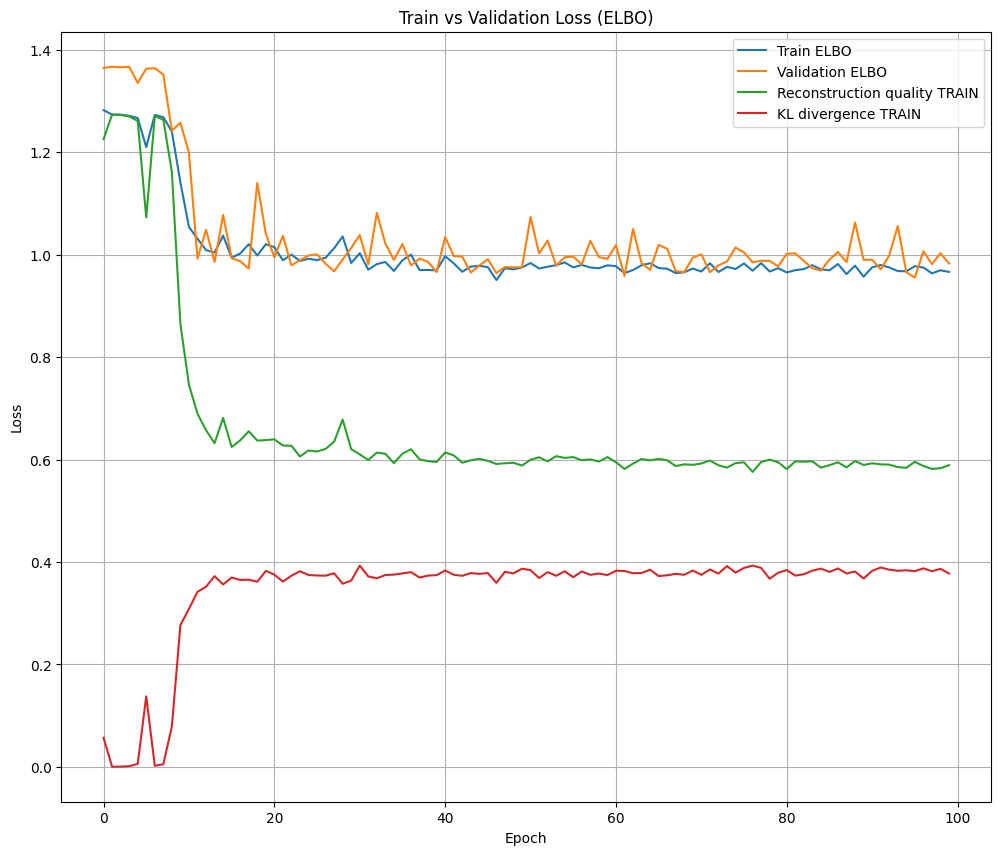

In [ ]:
# plt.figure(figsize=(12,10))
# plt.plot(train_losses, label='Train ELBO')
# plt.plot(val_losses, label='Validation ELBO')
# plt.plot(recon_trains, label='Reconstruction quality TRAIN')
# plt.plot(kld_trains, label ='KL divergence TRAIN')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Train vs Validation Loss (ELBO)")
# plt.grid(True)
# plt.savefig('expirements/epoch100/epoch100.png')
# plt.show()



In [ ]:
# model.eval()
# with torch.no_grad():
#     # Sample latent vectors from standard normal
#     z = torch.randn(len(df_vae), 2)
#     generated_log_counts = model.decode(z)
#     # Convert back to counts
#     generated_counts = torch.expm1(generated_log_counts).clamp(min=0).round().int()
# print(generated_counts[0:5])




tensor([[1, 0, 0],
        [3, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [3, 0, 0]], dtype=torch.int32)


In [ ]:
# after generating donor characteristics, 

# plot the proption of mutation , for each mutation type
# for synthetic data
 
# counts_array = generated_counts.numpy()

# # Create DataFrame
# df_gen = pd.DataFrame(
#     counts_array,
#     columns=['SNP', 'INS', 'DEL']
# )

# df_gen['Donor_ID'] = [f'Donor_{i+1}' for i in range(len(df_gen))]

# print(df_gen.head())


   SNP  INS  DEL Donor_ID
0    1    0    0  Donor_1
1    3    0    0  Donor_2
2    1    0    0  Donor_3
3    1    0    0  Donor_4
4    3    0    0  Donor_5


In [ ]:
df_vae.loc[:, 'Donor_ID'] = [f'Donor_{i+1}' for i in range(len(df_vae))]
df_vae.head()

,SNP,INS,DEL,Donor_ID
0,1,0,0,Donor_1
1,1,0,0,Donor_2
2,1,0,0,Donor_3
3,1,0,0,Donor_4
4,1,0,0,Donor_5


In [ ]:
# df_long = df_gen.melt(
#     id_vars=['Donor_ID'],
#     value_vars=['SNP', 'INS', 'DEL'],
#     var_name='Mutation_Type',
#     value_name='Count'
# )

# # Total mutations per donor
# df_long['Total'] = df_long.groupby('Donor_ID')['Count'].transform('sum')

# # Proportion
# df_long['Proportion'] = df_long['Count'] / df_long['Total']



# print(len(df_long))
# df_long.head()



52158


,Donor_ID,Mutation_Type,Count,Total,Proportion
0,Donor_1,SNP,1,1,1.0
1,Donor_2,SNP,3,3,1.0
2,Donor_3,SNP,1,1,1.0
3,Donor_4,SNP,1,1,1.0
4,Donor_5,SNP,3,3,1.0


In [ ]:
# df_long_real = df_vae.melt(
#     id_vars=['Donor_ID'],
#     value_vars=['SNP', 'INS', 'DEL'],
#     var_name='Mutation_Type',
#     value_name='Count'
# )

# # Total mutations per donor
# df_long_real['Total'] = df_long_real.groupby('Donor_ID')['Count'].transform('sum')

# # Proportion
# df_long_real['Proportion'] = df_long_real['Count'] / df_long_real['Total']

# print(df_long_real.head())




  Donor_ID Mutation_Type  Count  Total  Proportion
0  Donor_1           SNP      1      1         1.0
1  Donor_2           SNP      1      1         1.0
2  Donor_3           SNP      1      1         1.0
3  Donor_4           SNP      1      1         1.0
4  Donor_5           SNP      1      1         1.0


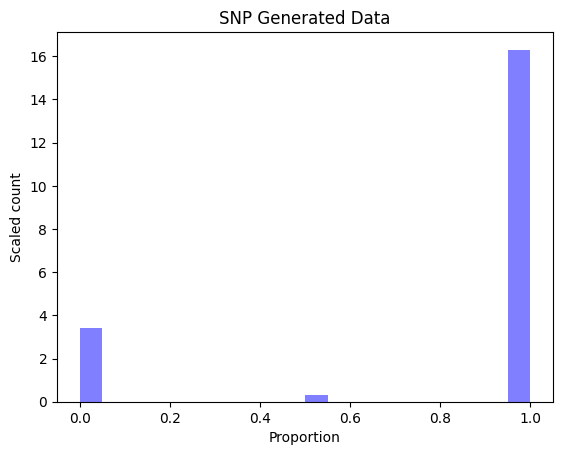

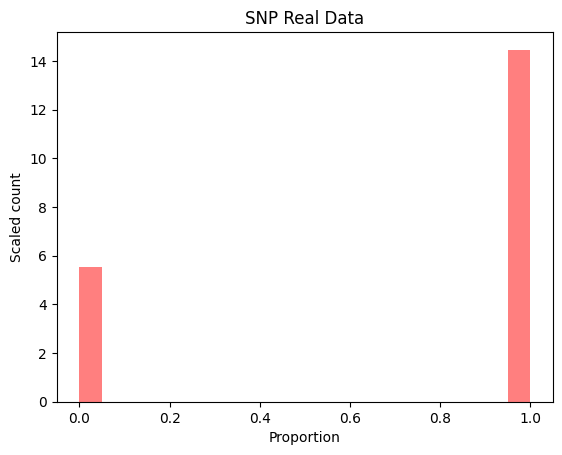

In [ ]:

import os



# df_snp= df_long[df_long['Mutation_Type']=='SNP'][['Proportion']]
# df_snp_real= df_long_real[df_long_real['Mutation_Type']=='SNP'][['Proportion']]
# plt.title('SNP Generated Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp, bins=20, alpha=0.5, label='Real', color='blue', density=True)
# wandb.log({"snp_generated": wandb.Image(plt)})
# plt.show()
# plt.title('SNP Real Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp_real, bins=20, alpha=0.5, label='Real', color='red', density=True)
# wandb.log({"snp_real": wandb.Image(plt)})
# plt.show()




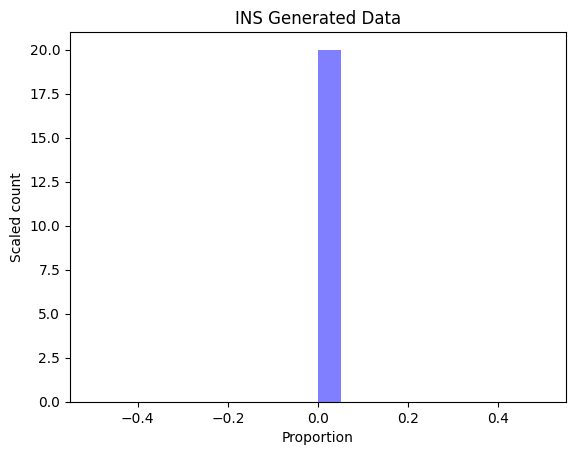

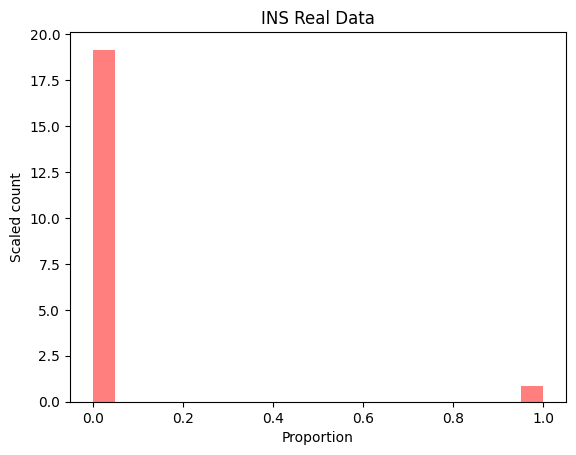

In [ ]:


# df_snp= df_long[df_long['Mutation_Type']=='INS'][['Proportion']]
# df_snp_real= df_long_real[df_long_real['Mutation_Type']=='INS'][['Proportion']]
# plt.title('INS Generated Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp, bins=20, alpha=0.5, label='Real', color='blue', density=True)

# wandb.log({"INS_generated": wandb.Image(plt)})
# plt.show()
# plt.title('INS Real Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp_real, bins=20, alpha=0.5, label='Real', color='red', density=True)
# wandb.log({"INS_real": wandb.Image(plt)})
# plt.show()


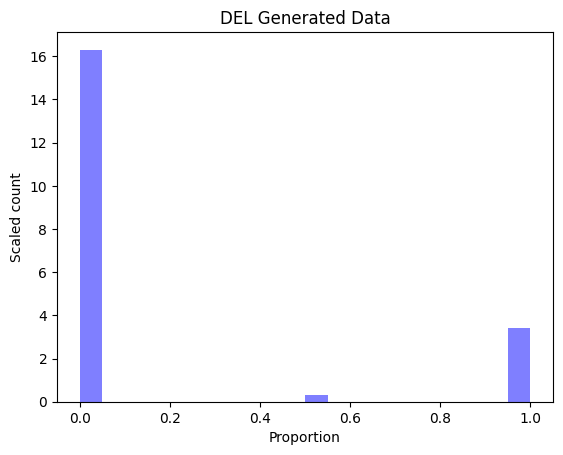

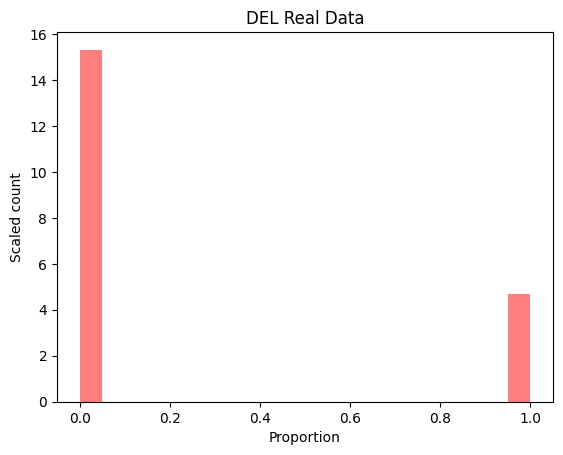

In [ ]:
# df_snp= df_long[df_long['Mutation_Type']=='DEL'][['Proportion']]
# df_snp_real= df_long_real[df_long_real['Mutation_Type']=='DEL'][['Proportion']]
# plt.title('DEL Generated Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp, bins=20, alpha=0.5, label='Real', color='blue', density=True)
# wandb.log({"DEL_generated": wandb.Image(plt)})
# plt.show()
# plt.title('DEL Real Data')
# plt.xlabel('Proportion')
# plt.ylabel('Scaled count')
# plt.hist(df_snp_real, bins=20, alpha=0.5, label='Real', color='red', density=True)
# wandb.log({"DEL_real": wandb.Image(plt)})
# plt.show()

In [ ]:
def describe(arr, name):
    min_val = np.min(arr)
    max_val = np.max(arr)
    range_val = max_val - min_val
    mean_val = np.mean(arr)
    std_val = np.std(arr)
    return f"{name} stats: \n  Min:  {min_val} \n Max:  {max_val} \n Range: {range_val} \n Mean: {mean_val:.3f} \n  Std Dev: {std_val:.3f}\n"
    






In [ ]:
# measure wasserstein distances
# could there be a corerlation between SNP, INS, and DEL

# real_snp = df_vae['SNP'].values
# synth_snp = df_gen['SNP'].values

# real_ins = df_vae['INS'].values
# synth_ins = df_gen['INS'].values

# real_del = df_vae['DEL'].values
# synth_del = df_gen['DEL'].values


from scipy.stats import wasserstein_distance

w_snp = wasserstein_distance(real_snp, synth_snp)
w_ins = wasserstein_distance(real_ins, synth_ins)
w_del = wasserstein_distance(real_del, synth_del)

print(f"Wasserstein distance for SNP: {w_snp:.3f}")
print(f"Wasserstein distance for INS: {w_ins:.3f}")
print(f"Wasserstein distance for DEL: {w_del:.3f}")

wandb.log({'wasserstein': f'snp: {w_snp}, ins: {w_ins}, del: {w_del}'})



Wasserstein distance for SNP: 3.988
Wasserstein distance for INS: 0.053
Wasserstein distance for DEL: 0.248


In [ ]:
print(real_desc_snp := describe(real_snp, "SNP"))
print(real_desc_ins := describe(real_ins, "INS"))
print( real_desc_del := describe(real_del, "DEL"))





SNP stats: 
  Min:  0 
 Max:  865 
 Range: 865 
 Mean: 6.925 
  Std Dev: 31.634

INS stats: 
  Min:  0 
 Max:  12 
 Range: 12 
 Mean: 0.053 
  Std Dev: 0.291

DEL stats: 
  Min:  0 
 Max:  132 
 Range: 132 
 Mean: 0.486 
  Std Dev: 1.970



In [ ]:
print(synth_snp:=describe(synth_snp, "SNP"))
print(synth_ins:= describe(synth_ins, "INS"))
print(synth_del:= describe(synth_del, "DEL"))

# with open(f'{save_dir}/epoch{num_epochs}.txt', 'w') as file:
#     file.write(f"Wasserstein distance for SNP: {w_snp:.3f}\n Wasserstein distance for INS: {w_ins:.3f}\n Wasserstein distance for DEL: {w_del:.3f}\n" )
#     file.write(f" REAL SUMMARY \n {real_desc_snp}\n {real_desc_ins} \n {real_desc_del} \n")
#     file.write(f" SYNTH SUMMARY \n {synth_snp}\n {synth_ins} \n {synth_del} \n")

# wandb.log({"log_text": message})

SNP stats: 
  Min:  0 
 Max:  422 
 Range: 422 
 Mean: 3.151 
  Std Dev: 12.505

INS stats: 
  Min:  0 
 Max:  0 
 Range: 0 
 Mean: 0.000 
  Std Dev: 0.000

DEL stats: 
  Min:  0 
 Max:  12 
 Range: 12 
 Mean: 0.237 
  Std Dev: 0.611



C:\Users\25193\AppData\Local\Temp\ipykernel_26712\3646451444.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis', alpha=0.7)


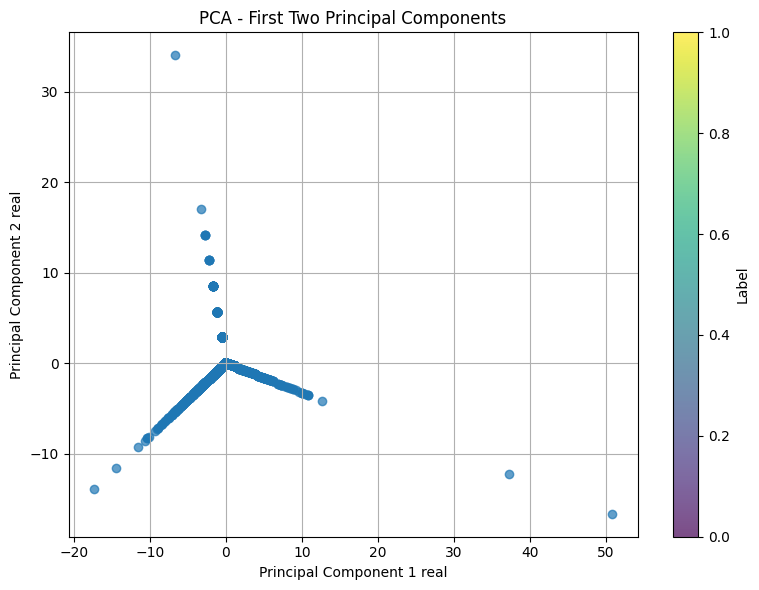

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_vae[['SNP', 'INS', 'DEL']])

# 2. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# 3. Convert result to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])


# 5. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1 real')
plt.ylabel('Principal Component 2 real')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\25193\AppData\Local\Temp\ipykernel_26712\2875933960.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis', alpha=0.7)


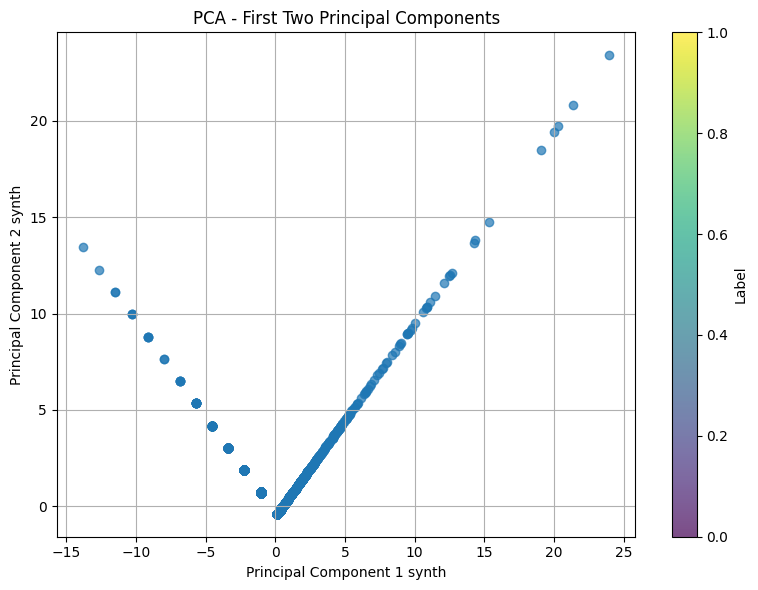

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_gen[['SNP', 'INS', 'DEL']])

# 2. Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# 3. Convert result to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])


# 5. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1 synth')
plt.ylabel('Principal Component 2 synth')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.grid(True)
plt.tight_layout()
plt.show()

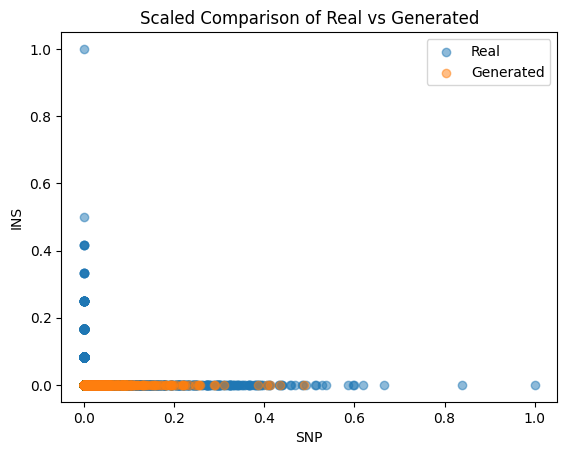

In [ ]:
feature_x = 'SNP'
feature_y = 'INS'
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

real_scaled = scaler.fit_transform(df_vae[[feature_x, feature_y]])
gen_scaled = scaler.transform(df_gen[[feature_x, feature_y]])

plt.scatter(real_scaled[:, 0], real_scaled[:, 1], alpha=0.5, label='Real')
plt.scatter(gen_scaled[:, 0], gen_scaled[:, 1], alpha=0.5, label='Generated')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Scaled Comparison of Real vs Generated")
plt.legend()
plt.show()



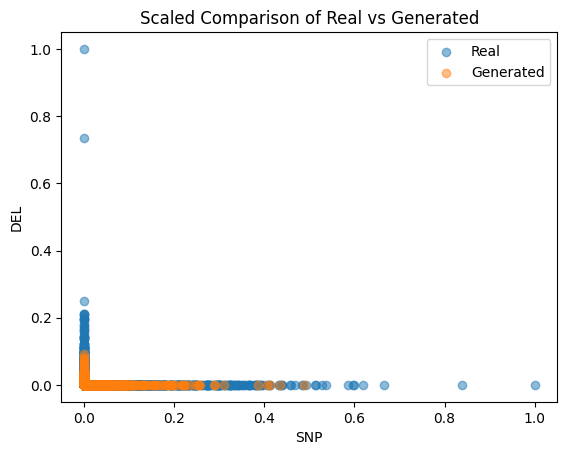

In [ ]:
# Choose two features
feature_x = 'SNP'
feature_y = 'DEL'
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

real_scaled = scaler.fit_transform(df_vae[[feature_x, feature_y]])
gen_scaled = scaler.transform(df_gen[[feature_x, feature_y]])

plt.scatter(real_scaled[:, 0], real_scaled[:, 1], alpha=0.5, label='Real')
plt.scatter(gen_scaled[:, 0], gen_scaled[:, 1], alpha=0.5, label='Generated')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Scaled Comparison of Real vs Generated")
plt.legend()
plt.show()
